# Aprendizaje por refuerzo en Mini-grid
## Laboratorio 2022 - Tarea 1

### Grupo 27 ###

Rafael Castelli, CI: 5.079.391-2

Alexis Baladón, CI: 5.574.612-4

Ignacio Viscardi, CI: 5.066.666-2







*Aprendizaje Automático*

*Facultad de IngenierÍa. Universidad de la República*

*Montevideo, Uruguay*

# 1. Objetivo

El objetivo de esta tarea es un implementar y evaluar a un agente que se mueva con éxito en
los mundos mini-gym.

# 2. Diseño

La finalidad de esta sección es introducir las principales decisiones de diseño tomadas para la implementación del agente y el algoritmo de entrenamiento.

## 2.1 Decisiones arquitectónicas

Brevemente se explicitan algunas decisiones arquitectónicas tomadas, de forma de facilitar al lector la comprensión del código presentado.

En su mayoría se respeta la arquitectura brindada por el código base, a excepción de dos archivos particulares "models/parameters.py" y "models/variables.py".

El archivo parameters.py se encarga de encapsular los pesos calculados para el modelo y variables.py se encarga de retornar los valores numéricos que dan la representación de un tablero particular. Esto se hace mediante los métodos store y vectorize de la clase parameters donde vectorize devuelve los pesos almacenados en memoria (que se inicializaran en un archivo con los parámetros del modelo).

En la clase variables se presenta el método publico vectorize, que dado un tablero, y algunas variables auxiliares (y opcionales, pues solo son necesarias para la simulación de movimientos) calcula un vector de valores reales que representan las variables del problema.

Particularmente:

w = [w0, w1, w2, ... , wn] vector de pesos
x = [1, x1, x2, ... , xn] vector de valores de variables

w = Parameters.vectorize()
x = Variables.vectorize(...)

(∀ t ∈ Tableros)(Intermedio(t) → V_approx(t) = x^t * v) 

Como se debe utilizar un modelo lineal, entonces se restringe que cualquier xi de x es el valor de una variable que representa a nuestro modelo, pero esta abstracción nos permite trivialmente generalizar a modelos no lineales considerando el valor de retorno de x como:

x(t) = [1, f1(t), f2(t), ..., fn(t)] con t un tablero intermedio

Dando una generalización trivial para modelos no lineales (que admitan por ejemplo, fi(t) = distancia_punto_verde*distancia_puerta*lava_in_front en vez de restringinse a fi(t) = distancia_punto_verde, fi+1(t) = distancia_puerta, ...)

Volviendo al punto original, el modelo solo implementa la lógica para determinar movimientos sin necesidad de conocer (prácticamente) nada de la representación del tablero, desacoplándolos. Es decir, mediante una serie de queries a Variables (y una query a Parameters para obtener los pesos de la combinación lineal) pasándole posibles estados siguientes del tablero y decidiendo (según algún criterio luego especificado) en base a dichas valoraciones el movimiento optimo a realizar.

Por otro lado, Variables se descompone en 2 clases auxiliares independientes que manejan información del agente e información del mundo, para delegar de forma más fina las responsabilidades. De modo informativo, se menciona la necesidad de crear una clase "Ninject" dentro de dicho que realiza el patrón singleton y factory para realizar inyecciones de dependencias de esas clases auxiliares y romper referencias circulares.

El módulo g27_l1_algo.py (de aquí en más "el algoritmo") implementa LMS para ajustar los pesos. Por otro lado, el módulo g27_l1_train.py implementa la recolección de experiencias mediante jugadas, para "dárselas" al algoritmo y ajustar las rewards que da minigrid. Es importante destacar que luego de experimentar, se considera apropiado poder utilizar rewards distintas a las brindadas por minigrid y por tanto se utilizan rewards "custom".

## 2.2: Modelo conceptual

Para la elaboración del obligatorio fue seguida la línea de razonamiento presentada en el capítulo de 1 de Mitchell, T. M. (1997). Machine Learning.

A su vez, a medida que se avanza en el diseño y se experimenta, se veía más necesario realizar modificaciones o mejoras iterativas al diseño.

### 2.2.1: Tarea de entrenamiento

Primeramente, es formulada la siguiente tarea de entrenamiento:

- Tarea T: Jugar un tablero de minigrid dentro de una colección "aleatoria" con determinadas características (por ejemplo, aprender a jugar los tableros del tipo MiniGrid-LavaCrossingS9N1-v0 y similares como MiniGrid-LavaCrossingS11N5-v0)

- Medida de performance P: Porcentaje de juegos ganados en los mapas objetivos.  Para experimentar, además se calculará el porcentaje de juegos ganados en un mapa con características distintas al set de mapas objetivo a aprender (por ejemplo, "transferencia de conocimientos" entre MiniGrid-Empty-8x8-v0 y MiniGrid-FourRooms-v0).

- Experiencia de E: Jugar n veces en el set de mapas objetivos, con una cantidad de pasos m máxima por mapa y observar el valor de retorno del ambiente. 

Como se verá posteriormente, el modelo lineal presentado no es lo suficientemente expresivo para dar un buen rendimiento en cualquier tipo de mapas, y el conocimiento fruto del entrenamiento en un tipo de mapas no necesariamente se transmite a otro tipo de mapas (por ejemplo de mapas con paredes a mapas con lava) y por esto se restringe la tarea T respecto a "Resolver tableros minigrid aleatorios". Además, no se consideran tableros con puertas ni llaves, ni enemigos, entre otros.

### 2.2.2: Especificación del conocimiento a aprender

Como es mencionado anteriormente, la tarea de aprender a jugar mapas MiniGrid puede reducirse a aprender a evaluar un conjunto de potenciales tableros a partir del estado actual y en base a dichas valoraciones elegir una acción que el modelo considere adecuada (luego se detallará como son utilizadas estas valoraciones).

Sea Tableros el conjunto de tableros MiniGrid posibles (con la posición y orientación del jugador), entonces se busca aprender una función:

$$V: Tableros ↦ D \subset ℜ$$

Particularmente, fue tomado D = [-100, 100] pues experimentalmente resultó favorable.

### 2.2.3: Función objetivo

Posteriormente, fue elegida la siguiente función objetivo:

$$t \in Tableros$$
$$ V(TableroLava(t)) = -100$$
$$ V(TableroGoal(t)) = 100$$
$$ V(TableroIntermedio(t)) = \gamma V(SiguienteMejorTablero(t))$$
Donde γ ∈ (0,1)

Además, cuando se queda sin pasos el algoritmo es penalizado con ganancia -100

Por todo lo visto en el curso, es elegida una aproximación operativa de la función objetivo

### 2.2.4: Aproximación operativa

A lo largo del informe y la experimentación son utilizadas diversas aproximaciones según las variables independientes del modelo. Particularmente, toda aproximación utilizada es de la forma:

$$Vapprox = w_0 + w_1*x_1 + ... + w_n*x_n$$

Especificamente es utilizado: $$x_i \in \{distanceToGoal, wallInFront, lavaInFront, goalInFront, wallParallel, corner, door, distanceToDoor\}$$

A lo largo del informe se experimenta con el uso de subconjuntos de estas variables. 

- constant_weight: Valor sin interpretación específica
- distance_to_goal: Devuelve la distancia al bloque verde
- wall_in_front: Ddevuelve 1 si el agente tiene una pared en frente, en otro caso devuelve 0
- lava_in_front: Devuelve 1 si el agente tiene lava en frente, en otro caso devuelve 0
- goal_in_front: Devuelve 1 si el agente tiene el goal en frente, en otro caso devuelve 0
- wall_parallel: Devuelve 1 si el agente está paralelo a una pared o lava, en otro caso devuelve 0
- in_a_corner: Devuelve si el agente está en una equina, en otro caso devuelve 0
- door_in_front: Devuelve si el agente está en frente a una puerta, en otro caso devuelve 0. Un bloque es considerado puerta si tiene dos muros o bloques de lava paralelos a su lado, y a la vez dos bloques vacíos en paralelo y a su lado.
- distance_to_door: Devuelve la distancia a la puerta más cercana dentro del rango de visión (si la hay), en otro caso devuelve el rango de visión.
- fell_in_lava: Devuelve 1 si el agente esta en un bloque de lava, en otro caso devuelve 0.

## 2.3: Modelo

Como fue mencionado anteriormente, el modelo evalúa diferentes tableros posibles, dentro de los permitidos para su posición actual, y con esa evaluación decide que acción tomar.

Particularmente, el modelo simula los siguientes 5 tableros:
  - a) Tablero resultante de moverse hacia adelante
  - b) Tablero resultante de girar en sentido horario
  - c) Tablero resultante de girar en sentido horario y después avanzar
  - d) Tablero resultante de girar en sentido antihorario
  - e) Tablero resultante de girar en sentido antihorario y después avanzar

El modelo pondera los 5 tableros, elige los tableros maximales (con una tolerancia ϵ=0.5% ajustable) y elije entre los tableros uno al azar entre aquellos con valor maximal.

- El tablero a) genera la acción de moverse hacia adelante.

- Los tableros b) y c) generan la acción de moverse en sentido horario

- Los tableros d) y e) generan la acción de moverse en sentido antihorario

Se agrega aleatoriedad para evitar estancarse en máximos locales de la función y explorar más el tablero. Como posible mejora, se podría reducir el nivel de aleatoriedad conforme el modelo es entrenado o utilizar estrategias que detecten estancamiento en máximos locales y después incrementando la aleatoriedad del modelo. Particularmente, se propone (pero no se implementa) para detectar estancamientos analizar la norma de la diferencia de los vectores de pesos entre una iteración y la siguiente. Si dicha norma queda por debajo de un δ (metaparámetro), y el reward no es positivo, entonces se detecta estancamiento en un óptimo local. En caso contrario, o bien el modelo todavía no convergía, o bien el modelo diverge o converge a un óptimo global (llegar a la meta). Debería analizarse la interacción de este mecanismo con la tasa de enfriamiento a modo de no generar conflictos. Nuevamente, esta solución no se implementa y solo se propone teóricamente. Sí se implementa el simple desempate aleatorio entre valores similares hasta una diferencia de ϵ.

Por defecto se habilita este mecanismo estocástico, pero puede ser desactivado pasando la flag --stochastic 0.

## 2.4: Método de entrenamiento (generación de experiencias)

Para generar experiencias de entrenamiento se considera una jugada entera, es decir, se generan experiencias por cada paso que el agente da desde que comienza a jugar un episodio hasta que el juego termina por algún motivo. La última experiencia es la única en donde se utiliza el reward que el mundo otorga al agente. Luego de una partida entera, se procesan las experiencias para ajustar el modelo y se realiza una nueva partida con los pesos ajustados.
Es decir, se entrena al final de cada partida.

## 2.5: Regla de estimación

Como regla de estimación de la función V se utiliza el algoritmo LMS, procesando las experiencias de fin a principio. Es decir, primero se ajusta con LMS utilizando la reward del mundo, luego con la experiencia anterior a finalizar, y así sucesivamente. Para cada experiencia se reajustan los pesos y se recalculan las valoraciones pertinentes según el algoritmo.

# 3. Experimentación

Con el fin de experimentar sobre el modelo y algoritmo implementado fueron generadas las pruebas más adelante presentadas. En ellas se presentarán la evaluación que se busca realizar, qué métrica es utilizada para cada una de ellas y finalmente los resultados de las mismas.

Para esto, el agente será estudiado tanto con visión como sin ella. Además, serán utilizados los siguientes 3 mapas ofrecidos por Mini-Grid:
- MiniGrid-Empty-8x8-v0 (mapa con cuatro paredes)
- MiniGrid-FourRooms-v0 (mapa con cuatro cuartos)
- MiniGrid-LavaCrossingS9N3-v0 (mapa con obstáculos y lava)

### 3.1 MiniGrid-Empty-8x8-v0
Se comenzó entrenando al agente en el mapa MiniGrid-Empty-8x8-v0, dicho mapa es un mapa de 8x8 casillas, en el cual no se presenta ningún tipo de obstáculo.

El primer paso a la hora de enfrentarnos a este mapa fue definir que parámetros representan el Mundo en el que el agente se encuentra inmerso. 

### 3.1.1 Ajuste de las variables del mundo

Dado que el mapa no presenta ningún tipo de obstáculos se decidió realizar los primeros entrenamientos utilizando la distancia al punto verde (meta) como única variable, además del término independiente. Dicha variable fue calculada utilizando la distancia norma 1.
Por lo que el vector de pesos W quedó definido como {w0, w1} siendo w0 término el independiente y w1 la distancia a la meta.


### 3.1.2 Entrenamiento agente visión total

El vector de pesos utilizado inicialmente fue el siguiente:
	W = {w0, w1} = {0, -1} 

Se tomo un peso negativo para la distancia, ya que se partió bajo el supuesto de que a mayor distancia peor valuación debería dar el mundo, o lo que es equivalente, mientras más cerca del punto verde mejor valuación debería obtener el mundo.

Luego de entrenar 100 veces al agente, con un límite de pasos de 20, el vector de pesos quedo definido de la siguiente manera:
			W = {62.27163932, -5.2846025}

Para evaluar al agente resultante, se utilizo como medida de performance la cantidad de partidas ganadas sobre la cantidad total de partidas jugadas.
El agente fue testeado utilizando un límite de 20 pasos en 100 partidas, a partir del siguiente comando:

```python ./test.py  --steps 20 --runs 100 --env MiniGrid-Empty-8x8-v0```

Se obtuvo una performance del 100% de partidas ganadas.

Luego, este mismo agente fue evaluado en los otros dos mapas.


### 3.1.3 Agente con visión acotada
 Se experimento con diferentes rangos de visión, utilizando la representación del mundo antes mencionada. A continuación, se presentan los resultados obtenidos.

-Agente con rango de visión de 5 bloques:
	Vector inicial: 	w = {0, -1}
	Entrenamiento: se realizaron 100 partidas con un límite de 30 pasos.

```python ./train.py --steps 30 --runs 100 --env MiniGrid-Empty-8x8-v0 --global_vision 0 --vision_range 5```


	Vector resultante: w = { 83.0466, -6.3508481 }


	Performance: 
		- Para 500 partidas, con límite de 30 pasos se obtuvo una performance de 285 / 500 => 57%	
		- Para 500 partidas, con límite de 40 pasos se obtuvo una performance de 383 / 500 => 76.6%
		- Para 500 partidas, con límite de 30 pasos se obtuvo una performance de 443 / 500 => 88.6%	

```python ./test.py --steps X --runs 500 --env MiniGrid-Empty-8x8-v0 --global_vision 0 --vision_range 5```


-Agente con rango de visión de 4 bloques:
	Vector inicial: 	w = {0, -1}
	Entrenamiento: se realizaron 100 partidas con un límite de 30 pasos.

```python ./train.py --steps 30 --runs 100 --env MiniGrid-Empty-8x8-v0 --global_vision 0 --vision_range 4```


	Vector resultante: w = { 78.56974, -1.028481 }
	

	Performance: 
		- Para 500 partidas, con límite de 30 pasos se obtuvo una performance de 230 / 500 => 46%
		- Para 500 partidas, con límite de 40 pasos se obtuvo una performance de 304 / 500 => 60.8%
		- Para 500 partidas, con límite de 30 pasos se obtuvo una performance de 355 / 500 => 71%	

```python ./test.py --steps X --runs 500 --env MiniGrid-Empty-8x8-v0 --global_vision 0 --vision_range 4```

-Agente con rango de visión de 3 bloques:
	Vector inicial: 	w = {0, -1}
	Entrenamiento: se realizaron 100 partidas con un límite de 30 pasos.

```python ./train.py --steps 30 --runs 100 --env MiniGrid-Empty-8x8-v0 --global_vision 0 --vision_range 3```


	Vector resultante: w = {87.41228461, -8.82268278}
	

	Performance: 
		- Para 500 partidas, con límite de 30 pasos se obtuvo una performance de 156 / 500 => 31.2%
		- Para 500 partidas, con límite de 40 pasos se obtuvo una performance de 228 / 500 => 45.6%
		- Para 500 partidas, con límite de 30 pasos se obtuvo una performance de 307 / 500 => 61.4%	

```python ./test.py --steps X --runs 500 --env MiniGrid-Empty-8x8-v0 --global_vision 0 --vision_range 3```

De lo presentado anteriormente se puede concluir que el rango de visión es un factor determinante para el éxito del agente, al menos para la representación del mundo en la cual solo se considera la distancia al punto verde. Esto era algo esperable ya que, si la distancia al punto verde es mayor que el rango de visión entonces el agente no va a saber para donde moverse, debido a que todos los movimientos posibles evaluaran lo mismo. Mas se abordará este mismo problema pero considerando una representación del mundo con mas variables, la que me permite obtener mejores resultados, incluso con visión acotada.

### 3.1.4 Evaluación del agente con visión total en otros mapas 

En el caso del mundo MiniGrid-FourRooms-v0, el agente fue capaz de resolver 82/200 partidas. Además, observamos que en las partidas en las que el agente gana, o bien aparece en la misma habitación que la meta, o bien queda en una habitación adyacente alineado a la meta y la pasada. En cualquier otro caso, el no es capaz de alcanzar la meta. 
Comando de testeo:
``` python ./test.py --env MiniGrid-FourRooms-v0 --steps 50 --runs 200 ```


En el caso del mundo MiniGrid-LavaCrossingS9N3-v0, y como era de esperarse, el agente no fue capaz de resolver ninguna de las partidas a las que se enfrentó.

``` python ./test.py --env MiniGrid-LavaCrossingS9N3-v0 --steps 50 --runs 200 ```

Estos resultados eran de esperarse ya que las variables que modelan el mundo no contemplan otros parámetros más que la distancia al punto verde, por lo que el agente no es capaz de “darse cuenta” que tiene un obstáculo en su camino.

### 3.1.5 Nuevas variables del mundo
 Dado los resultados obtenidos por el agente con una sola variable, decidimos agregar nuevas variables las cuales le permitieran al agente obtener un mayor desempeño tanto en otros tableros o como con visión parcial. Para ello consideramos las siguientes variables: wall_in_front, lava_in_front, goal_in_front, wall_parallel, in_a_corner, door_in_front, distance_to_door. Estas variables ya fueron definidas en la parte 2 del presente informe.

### 3.1.6 Agente con vision total y nuevas variables

Para este experimento se entrena al agente en el mapa MiniGrid-Empty-8x8-v0, con un vector inicial tal que le indica al agente que debe acercarse al goal (específicamente, se pondera como bueno disminuir la distancia al objetivo). A continuación se incluye dicho vector:

<table>
<tr>
  <th>constant_weight</th>
  <th>distance_to_goal</th>
  <th>wall_in_front</th>
  <th>lava_in_front</th>
  <th>goal_in_front</th>
  <th>wall_parallel</th>
	<th>in_a_corner</th>
	<th>door_in_front</th>
  <th>distance_to_door</th>
  <th>fell_in_lava</th>
</tr>
<tr>
  <th>0</th>
  <th>-1</th>
  <th>0</th>
  <th>0</th>
  <th>0</th>
  <th>0</th>
  <th>0</th>
  <th>0</th>
  <th>0</th>
    <th>0</th>
  <caption>{
  "parametros": [
    0,
    -1,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0
  ]
}</caption>
</tr>
</table>

Se entrena el modelo de la siguiente forma:


```
python train.py --runs 100 --steps 20 --env MiniGrid-Empty-8x8-v0
```

Y se obtiene el siguiente vector de pesos (para la reproducibilidad de los experimentos se debe recordar que existen decisiones aleatorias tomadas por el modelo en algunos puntos):

<table>
<tr>
<th>constant_weight</th> 
<th>distance_to_goal</th>
<th>wall_in_front</th>   
<th>lava_in_front</th>
<th>goal_in_front</th>
<th>wall_parallel</th>
<th>in_a_corner</th>
<th>door_in_front</th>
<th>distance_to_door</th>
<th>fell_in_lava</th>
</tr>
<tr>
<th>45.62392702824489</th>
<th>-9.209409275808804</th>
<th>-6.007136286029776</th>
<th>0.0</th>
<th>6.106447039678199</th>
<th>46.49779884042866</th>
<th>-1.708953039430464</th>
<th>0.0</th>
<th>0.0</th>
    <th>0</th>
</tr>
<caption>{
  "parametros": [
    45.62392702824489,
    -9.209409275808804,
    -6.007136286029776,
    0.0,
    6.106447039678199,
    46.49779884042866,
    -1.708953039430464,
    0.0,
    0.0,
    0
  ]
}</caption>
</table>

Analizando visualmente lo que sucede, en el mapa vacío el agente encuentra un camino óptimo (de hecho, el camino óptimo para dicho mapa) recorriendo siempre por las paredes.
Luego, el agente aprende que es una "buena" estrategia seguir por las paredes del mapa para llegar a la meta.
Esto se verifica en el vector de pesos al asignarle el valor 46.49779884042866 al peso de la variable "wall_parallel".





## 3.2 MiniGrid-FourRooms-v0

### 3.2.1 Desempeño del agente en MiniGrid-FourRooms-v0 al entrenar en MiniGrid-Empty-8x8-v0

Posteriormente, al insertar el agente en el mundo MiniGrid-FourRooms-v0, se observa que el agente sigue una estrategia similar, acercándose a los muros para resolver el mapa.
Ejecutando (Se agregan steps pues el mapa es más grande):


```
python test.py --runs 400 --steps 50 --env MiniGrid-FourRooms-v0
```

Se obtiene un desempeño de 257 / 400, es decir 64.25%.
Como el agente logra resolver un porcentaje considerable de mundos, entonces se puede concluir que la experiencia en el mapa vacío le enseña información útil para resolver el mapa con 4 habitaciones, mostrando (en una primera instancia) que el modelo es capaz de generalizar más allá de mapas con características similares ("dentro del mismo conjunto", como todos los mapas aleatorios generados por una misma variable env).

Además, dado que el mundo tiene 4 habitaciones y suponiendo que el agente y el objetivo tienen distribución uniforme e independiente de aparecer en cada habitacion, se tiene una probabilidad de 25% (4 casos favorables / 16 casos posibles) de que el agente y el objetivo aparezcan en el mismo mapa, degenerando en un mapa practicamente análogo al mundo vacío.

Como tiene una performance P = 64.25% y solo un 25% de los mapas totales los podemos considerar como casos triviales, entonces esto nos indica que el agente obtuvo algún conocimiento útil de sus experiencias pasadas en otro mapa.

Además, tiene una probabilidad mayor a 1/2 de ganar un mapa (segun la estadística anterior), por lo que podemos decir no los resuelve por puro azar (ádemas de por la complejidad intrínseca del mapa)

Trivialmente se observa que el agente resuelve aquellos mapas análogos al mapa vacío.

Por otro lado vale la pena mencionar, que el mapa MiniGrid-Empty-8x8-v0 no se genera de forma aleatoria, y tiene un sesgo particular (que es en gran parte el responsable de la generalización que puede hacer el agente): El agente y el objetivo se encuentran ambos al lado de una pared, con el objetivo encontrándose en una esquina y el agente mirando en la direccion del objetivo paralelo al muro. Luego, trivialmente el camino más corto en dicho mapa pasa por recorrer al lado de una pared.
Es esperable entonces, por las particularidades del mapa en que se entrena, que el agente entienda como favorable mantenerse paralelo a una pared, que resulta ser una estrategia razonable para resolver laberintos, como puede ser los mapas de 4 paredes generados por minigrid.

Luego, el agente efectivamente generaliza conocimiento, pero en este caso se podria concluir que dicha generalización es útil "por azar" y queda (realizando solo experimentos en este mapa) la duda de si el agente efectivamente puede realizar generalizaciones correctas o favorables.

Observando el mapa MiniGrid-Empty-16x16-v0 se puede ver que sufre del mismo sesgo y por tanto es razonable esperar resultados similares.

El otro mapa vacío que ofrece minigrid es MiniGrid-Empty-Random-5x5-v0, que consiste en una habitacion de 3x3 (5x5 contando paredes). Con un mapa tan chico, el sesgo se mantiene. Particularmente el objetivo siempre queda en la esquina inferior derecha y el agente tiene una probabilidad de 7/8 de aparecer en un cuadrado adyacente a la pared, sin importar la posicion respecto a la pared, que si es relevante para medir el sesgo anterior.

Repitiendo el experimento con:

```
python train.py --runs 400 --steps 50 --env MiniGrid-Empty-Random-5x5-v0
python test.py --runs 400 --steps 50 --env MiniGrid-FourRooms-v0
```
Se obtiene: P = 149 / 400 = 37.25%
Confirmando el sesgo de los mapas anteriores.
No obstante, se puede deducir que este mapa, pese a su aleatoriedad, contiene (en menor medida) el mismo sesgo pero que de todas formas se puede generalizar conocimiento del mapa vacío.

### 3.2.2 Desempeño del agente en MiniGrid-FourRooms-v0 al entrenar en MiniGrid-Empty-8x8-v0 con vision acotada

Dado el vector obtenido en el mapa vacío, se prueba el mismo con visión acotada:

```
py .\test.py  --runs 1000 --steps 30  --env "MiniGrid-FourRooms-v0" --global_vision 0 --vision_range 5 
```

Este logra llegar a la meta 317 de un total de 1000 intentos. Sin duda demuestra que la falta de visión no es aún impedimento para la cantidad de partidas ganadas. Sin embargo, la performance se ve altamente perjudicada si comparamos con el resultado de la vision total.


### 3.2.3 Entrenamiento y convergencia del aprendizaje

  El agente fue entrenado utilizando diferentes vectores de pesos iniciales. Para todos ellos el resultado no fue el esperado. Luego de reiterados entrenamientos el vector terminaba divergiendo. Para intentar solventar dicho problema se plantearon distintas estrategias, como por ejemplo quitar variables, agregar nuevas variables, usar tazas de enfriamiento, entre otras cosas.
  Ninguna de ellas fue fructífera. Notamos que al quitar la variable distance_to_door el vector de pesos divergía más lento o se estancaba en un óptimo local. Esto se puede explicar porque la distancia, teniendo obstáculos, no parece ser una buena variable para un modelo lineal como en el que estamos trabajando.
  
  Posteriormente adjuntamos una gráfica que muestra el comportamiento del vector de pesos, partiendo de un vector con una perfomance de más de 50% (el vector obtenido de entrenar en el mapa sin obstáculos).

  Entrenamiento realizado:
```
py \train.py --runs 10 --steps 25 –test 1 --env MiniGrid-FourRooms-v0  
```

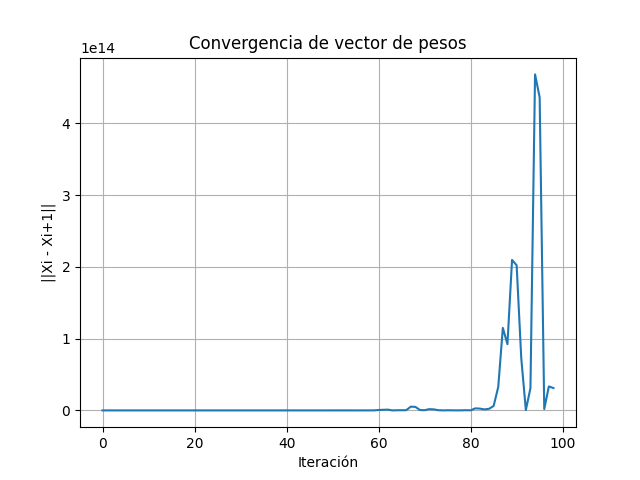

## 3.3 MiniGrid-LavaCrossingS9N3-v0

### 3.3.1 Desempeño del agente en MiniGrid-LavaCrossingS9N3-v0 al entrenar en MiniGrid-Empty-8x8-v0

Intentando entrenar al agente en este mapa con el vector entrenado en el mapa vacío con visión acotada, no fue posible obtener ninguna victoria. Esto era de esperarse debido a que en el mapa MiniGrid-Empty-8x8-v0 no existe lava ni caminos complejos. Esto parece indicar que el agente no es capaz de generalizar lo aprendido en un mapa sencillo al jugar en un mapa con lava.

### 3.3.2 Entrenamiento y convergencia del aprendizaje

El agente fue entrenado utilizando diferentes vectores de pesos iniciales. Para todos ellos el resultado no fue el esperado. Luego de reiterados entrenamientos el vector terminaba divergiendo. Para intentar solventar dicho problema se plantearon distintas estrategias, como por ejemplo quitar variables, agregar nuevas variables, usar tazas de enfriamiento, entre otras cosas. Ninguna de ellas fue fructífera. Notamos que al quitar la variable distance_to_door el vector de pesos divergia mas lento o se estancaba en un optimo local. Esto se puede explicar porque la distancia, teniendo obstáculos, no parece ser una buena variable para un modelo lineal como en el que estamos trabajando.

Aún así, con un vector obtenido experimentando con distintos valores, se logra llegar a la meta 234 de 1000 intentos.

## 3.3 MiniGrid-LavaCrossingS9N3-v0

### 3.3.1 Desempeño del agente en MiniGrid-LavaCrossingS9N3-v0 al entrenar en MiniGrid-Empty-8x8-v0

Intentando entrenar al agente en este mapa con el vector entrenado en el mapa vacío con visión acotada, no fue posible obtener ninguna victoria. Esto era de esperarse debido a que en el mapa MiniGrid-Empty-8x8-v0 no existe lava ni caminos complejos. Esto parece indicar que el agente no es capaz de generalizar lo aprendido en un mapa sencillo al jugar en un mapa con lava.

### 3.3.2 Entrenamiento y convergencia del aprendizaje


Se entrena al agente con distintos pesos iniciales. Se obtiene finalmente que el vector diverge.
El agente fue entrenado utilizando diferentes vectores de pesos iniciales. Para todos ellos el resultado no fue el esperado. Luego de reiterados entrenamientos el vector terminaba divergiendo. 

Para intentar solventar dicho problema se plantearon distintas estrategias, específicamente la mismas mencionadas en la sección 3.2. De forma similar, estas tampoco surtieron efecto. Se observa que al quitar la variable distance_to_door, se obtienen resultados con un mejor desempeño al mencionado anteriormente. Puntualmente, tomando un vector inicial que fue considerado intuitivamente favorable, luego de 200 entrenamientos con un límite de 30 pasos fue obtenido un incremento en la performance de un 15%.

<table>
<tr>
<th>constant_weight</th>
<th>distance_to_goal</th>
<th>wall_in_front</th>
<th>lava_in_front</th>
<th>goal_in_front</th>
<th>wall_parallel</th>
<th>corner</th>
<th>door</th>
<th>distance_to_door</th>
    <th>fell_in_lava</th>
</tr>
<tr>
<th>30.65542477175244</th>
<th>-4.32445364720577</th>
<th>-6.11602247667646</th>
<th>-1.0</th>
<th>2.439413787712129</th>
<th>60.65542477175255</th>
<th>-0.4072405414351946</th>
<th>0.0</th>
<th>0.0</th>
    <th>0</th>
</tr>
<caption>{
  "parametros": [
    30.65542477175244,
    -4.32445364720577,
    -6.11602247667646,
    -1.0,
    2.439413787712129,
    60.65542477175255,
    -0.4072405414351946,
    0.0,
    0.0,
    0.0,
  ]
}</caption>
</table>

Con el mismo vector y con visión acotada se logra llegar a la meta 234 de 1000 intentos.

```
py .\test.py --runs 100 --steps 30 --global_vision 0 --vision_range 5  --env "MiniGrid-LavaCrossingS9N3-v0"
```

Para el mapa de lava, no lograron hallarse valores para los que convergiera haciendo uso de todas las variables. Sin embargo, al quitar la variable de distancia a una puerta (cabe destacar que en esta implementación una puerta puede estar formada por lava), siempre se convergía a un vector en particular. De todos modos, este vector no lograba llegar al objetivo en ninguna ocasión. 

```
py .\test.py  --runs 100 --steps 30 --test 1 --env "MiniGrid-LavaCrossingS9N3-v0" 
```

A continuación se muestra una gráfica donde se observa su divergencia:

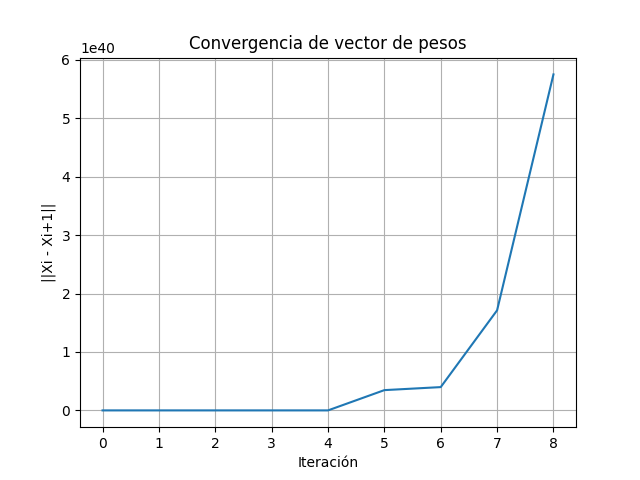

## 4. Conclusión

### 4.1 Resultados según expectativas iniciales
En general, el agente ha dado resultados que alcanzan la resolución de 100% de las partidas en un mapa vacío, lo cual es considerado altamente positivo. Sin embargo, en cuanto a el entrenamiento del agente, los resultados sorprenden de forma negativa dada la divergencia del vector de pesos al igual que las diversas situaciones en las que no entrena de forma correcta, principalmente al tener un vector de pesos inicial con valores intuitivamente malos. Por esto, se hace clara la importancia tanto del modelo como de un algoritmo, ya que un buen modelo es capaz de resolver un problema de forma satisfactoria con los parámetros adecuados, pero cuando los parámetros óptimos no son claros es el algoritmo el que juega un rol importante.


### 4.2 ¿Cuándo se dieron los mejores resultados?
Los mejores resultados del jugador se dieron cuando el jugador tenía inicialmente un vector con valores intuitivamente positivos. En cuanto a los diversos mapas, como era de esperarse, se vio una clara superioridad en los más sencillos con respecto a los difíciles, resultando aún así el agente bueno al sobreajustarse a mapas menos complejos y ser probado en otros. En cuanto a sobreajuste, se considera importante resaltar que el agente lograba generalizar lo aprendido en mapas sencillos en mapas más complejos, logrando de forma contraintuitiva superar más problemas de los que se creía que podía lograr. Especialmente, la posibilidad del agente de elegir su próximo movimiento de forma estocástica fue crucial para lograr explorar el tablero y no cometer un mismo error de forma incesante. También se vio que añadir una mejor cantidad de variables no siempre era beneficioso para el desempeño del agente y que para un mapa sencillo solo dos variables eran suficientes para lograr un buen desempeño. Por otro lado, el agente sin visión no lograba buenos resultados, aunque lograba un desempeño mejor que lo esperado al ser probado en mapas sencillos.

### 4.3 ¿Cómo mejoraría los resultados?
Claramente hay lugar para la mejora en el modelo y algoritmo planteado. En general, en cuanto a parámetros elegidos, se concluye que fueron buenas elecciones y poco puede hacerse al respecto para lograr una mejora significativa sin añadir mejoras más complejas. Por otro lado, en cuanto al algoritmo, se ven claras falencias con respecto a su aprendizaje del mismo, en particular, en la divergencia de su vector inicial, además de que rara vez aprende de forma esperada para un gran número de mapas y vectores de pesos iniciales. Se considera que uno de los factores detrás de estos resultados es el sesgo inductivo producido por suponer que el modelo se ajusta a una función lineal. Aún así, es probable que alguna modificación extra, tal como el factor de decaimiento comentado en secciones anteriores, podría solucionar varios problemas presentados por este, tales como la divergencia del vector de pesos que muchas veces causa un overflow en el programa. Esto último podría también solucionarse normalizando dicho vector, aunque la idea fue descartada dado que además se estarían considerando no factibles vectores de norma mayor que podrían obtener mayores resultados.